In [54]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Define the path to the Excel file relative to the notebook
excel_file_path = '../data/Muestra Proyecto Socios Formadores.xlsx'

# Load the data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Display the first few rows of the DataFrame to verify
df.head()

,Orden,Sucursal,FechaID,HoraLLegada,TurnoID,Turno,TurnoTipo,TurnoHoraInicio,TurnoHoraFin,TurnoMinutosEspera,TAPRecepcionMinutos,TAPRecepcionCaja
0,316483,COYOACAN,20240301,6,41684208,N015,Solicitar Estudios,06:02:44,06:13:23,NaN,NaN,NaN
1,316499,COYOACAN,20240301,6,41684414,N025,Solicitar Estudios,06:09:35,06:19:43,10.13,NaN,NaN
2,316515,COYOACAN,20240301,6,41684824,N038,Solicitar Estudios,06:18:16,06:30:42,12.43,NaN,NaN
3,316531,COYOACAN,20240301,6,41684679,P004,Triage,06:25:09,06:27:01,1.87,NaN,NaN
4,316547,COYOACAN,20240301,6,41685173,C011,Citado,06:35:09,06:37:47,2.63,NaN,NaN


In [3]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59650 entries, 0 to 59649
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Orden                59650 non-null  int64  
 1   Sucursal             59650 non-null  object 
 2   FechaID              59650 non-null  int64  
 3   HoraLLegada          59650 non-null  int64  
 4   TurnoID              59650 non-null  int64  
 5   Turno                59650 non-null  object 
 6   TurnoTipo            59650 non-null  object 
 7   TurnoHoraInicio      59650 non-null  object 
 8   TurnoHoraFin         59650 non-null  object 
 9   TurnoMinutosEspera   59649 non-null  float64
 10  TAPRecepcionMinutos  26316 non-null  float64
 11  TAPRecepcionCaja     26316 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 5.5+ MB


In [4]:
# Percentage of nulls in TAPRecepcionMinutos column by Sucursal
df.groupby('Sucursal')['TAPRecepcionMinutos'].apply(
    lambda x: x.isna().sum() / x.size
).reset_index()

,Sucursal,TAPRecepcionMinutos
0,COYOACAN,1.000000
1,CULIACAN,0.136917
2,CULIACAN CAÑADAS,0.185835
3,CULIACAN COLEGIO MILITAR,0.090451
4,CULIACAN LA CONQUISTA,0.153556


In [5]:
# are there duplicates in the data?
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [6]:
# Since Coyoacan has 100% nulls, we'll exclude it from the analysis
clinics_df = df[df['Sucursal'] != 'COYOACAN'].copy()

# Exploración sobre el tiempo de espera en la fila para ser atendido en ventanilla

In [7]:
# Convert time columns to strings, handling potential NaT or None values
clinics_df['TurnoHoraInicio_str'] = clinics_df['TurnoHoraInicio'].apply(
    lambda x: x.strftime('%H:%M:%S') 
    if pd.notna(x) and hasattr(x, 'strftime') else str(x)
)
clinics_df['TurnoHoraFin_str'] = clinics_df['TurnoHoraFin'].apply(
    lambda x: x.strftime('%H:%M:%S') 
    if pd.notna(x) and hasattr(x, 'strftime') else str(x)
)

# Combine FechaID (assuming YYYYMMDD format) and the time strings
# Convert FechaID to string first
clinics_df['FechaID_str'] = clinics_df['FechaID'].astype(str)

# Create combined datetime strings
start_datetime_str = clinics_df['FechaID_str'] + ' ' + clinics_df['TurnoHoraInicio_str']
end_datetime_str = clinics_df['FechaID_str'] + ' ' + clinics_df['TurnoHoraFin_str']

# Convert to datetime objects, coercing errors will turn unparseable entries into NaT
clinics_df['TurnoInicioDateTime'] = pd.to_datetime(
    start_datetime_str, 
    format='%Y%m%d %H:%M:%S', 
    errors='coerce'
)
clinics_df['TurnoFinDateTime'] = pd.to_datetime(
    end_datetime_str,
    format='%Y%m%d %H:%M:%S', 
    errors='coerce'
)

# Convert FechaID to datetime object separately
clinics_df['FechaID'] = pd.to_datetime(
    clinics_df['FechaID_str'], 
    format='%Y%m%d', 
    errors='coerce'
)

# Drop the intermediate string columns
clinics_df.drop(
    columns=[
        'FechaID_str', 'TurnoHoraInicio_str', 'TurnoHoraFin_str'
    ], 
    inplace=True
)

# Display the data types and first few rows to verify
print(clinics_df.info())
print(clinics_df[['FechaID', 'TurnoInicioDateTime', 'TurnoFinDateTime']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 30578 entries, 29072 to 59649
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Orden                30578 non-null  int64         
 1   Sucursal             30578 non-null  object        
 2   FechaID              30578 non-null  datetime64[ns]
 3   HoraLLegada          30578 non-null  int64         
 4   TurnoID              30578 non-null  int64         
 5   Turno                30578 non-null  object        
 6   TurnoTipo            30578 non-null  object        
 7   TurnoHoraInicio      30578 non-null  object        
 8   TurnoHoraFin         30578 non-null  object        
 9   TurnoMinutosEspera   30578 non-null  float64       
 10  TAPRecepcionMinutos  26316 non-null  float64       
 11  TAPRecepcionCaja     26316 non-null  float64       
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns]
 13  TurnoFinDateTime     30578 non-n

In [8]:
clinics_df['Turno'].apply(lambda x: x[0]).unique()

array(['P', 'N', 'C', 'F'], dtype=object)

At least there are 4 distinc major groups of "turnos".

As Salud Digna representative explained, "P" stands for priority.

In [9]:
clinics_df['TurnoGrupo'] = clinics_df['Turno'].apply(lambda x: x[0])

In [10]:
clinics_df['TurnoTipo']

29072     Estudio Pendiente
29073    Solicitar Estudios
29074                Citado
29075    Solicitar Estudios
29076    Solicitar Estudios
                ...        
59645     Citados sin folio
59646    Solicitar Estudios
59647    Solicitar Estudios
59648    Solicitar Estudios
59649    Solicitar Estudios
Name: TurnoTipo, Length: 30578, dtype: object

In [11]:
clinics_df[clinics_df['TurnoGrupo'] == 'F']['TurnoTipo'].unique()

array(['Folio Pagado', 'Cotizacion'], dtype=object)

In [12]:
clinics_df[clinics_df['TurnoGrupo'] == 'C']['TurnoTipo'].unique()

array(['Citado'], dtype=object)

In [13]:
clinics_df[clinics_df['TurnoGrupo'] == 'P']['TurnoTipo'].unique()


array(['Estudio Pendiente', 'Examen de la Vista', 'Triage',
       'Atención Empresas', 'Abono a Lentes', 'Entrega de Resultados'],
      dtype=object)

In [14]:
clinics_df[clinics_df['TurnoGrupo'] == 'N']['TurnoTipo'].unique()

array(['Solicitar Estudios', 'Citados sin folio'], dtype=object)

Observamos que los turnos con C son para personas que ya vienen con citas, los F son para personas con folio pagado, los P son los que tiene prioridad (según lo que nos dijo Salud Digna), y los N son los de turno "normal".

In [15]:
clinics_df['WaitingTimeInLine'] = clinics_df['TurnoFinDateTime'] - clinics_df['TurnoInicioDateTime']

In [16]:
clinics_df['WaitingTimeInLine'].describe()

count                        30578
mean     0 days 00:06:55.121002027
std      0 days 00:11:37.730917810
min                0 days 00:00:00
25%                0 days 00:00:08
50%                0 days 00:02:00
75%                0 days 00:07:50
max                0 days 01:28:39
Name: WaitingTimeInLine, dtype: object

In [17]:
# Is there a difference in waiting times between the different groups?
clinics_df.groupby('TurnoGrupo')['WaitingTimeInLine'].agg('mean')

TurnoGrupo
C   0 days 00:01:25.159525979
F   0 days 00:01:13.912738214
N   0 days 00:08:54.758379257
P   0 days 00:02:00.697976878
Name: WaitingTimeInLine, dtype: timedelta64[ns]

Observamos que el tiempo de espera para los pacientes P es considerablemente menor que para los pacientes N. Lo mismo sucede con C y F. Esto es verdad para el conjunto de todas las sucursales de esta base de datos.

In [18]:
mean_waiting_times_per_sucursal = clinics_df.groupby(
    ['Sucursal', 'TurnoGrupo']
)['WaitingTimeInLine'].agg('mean')
mean_waiting_times_per_sucursal

Sucursal                  TurnoGrupo
CULIACAN                  C            0 days 00:01:02.713988919
                          F            0 days 00:01:04.925925925
                          N            0 days 00:04:31.787832864
                          P            0 days 00:01:30.888743455
CULIACAN CAÑADAS          C            0 days 00:01:24.765641569
                          F            0 days 00:01:05.629268292
                          N            0 days 00:06:07.717369136
                          P            0 days 00:01:52.910423452
CULIACAN COLEGIO MILITAR  C            0 days 00:02:01.741035856
                          F            0 days 00:01:35.948051948
                          N            0 days 00:18:45.296389437
                          P            0 days 00:02:40.516835016
CULIACAN LA CONQUISTA     C            0 days 00:01:59.841059602
                          F            0 days 00:01:39.291666666
                          N            0 days 00:10:2

Lo mismo se observa para cada sucursal en individual.

In [19]:
# Convert the Series result back to a DataFrame for plotting
df_plot = mean_waiting_times_per_sucursal.reset_index()
df_plot.rename(
    columns={'WaitingTimeInLine': 'MeanWaitingTime'}, 
    inplace=True
) # Rename the value column for clarity

# Convert the timedelta mean waiting time to total seconds for plotting
df_plot['MeanWaitingTimeSeconds'] = df_plot['MeanWaitingTime'].dt.total_seconds()

# --- 2. Generate Heatmap ---
# Pivot the DataFrame to get 'Sucursal' as index, 'TurnoGrupo' as columns, and 'MeanWaitingTimeSeconds' as values
heatmap_data = df_plot.pivot(
    index='Sucursal', 
    columns='TurnoGrupo', 
    values='MeanWaitingTimeSeconds'
)

plt.figure(figsize=(10, 8)) # Adjust figure size as needed
# Use the heatmap_data based on seconds
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Mean Waiting Time Heatmap by Sucursal and TurnoGrupo', fontsize=16)
plt.xlabel('Turno', fontsize=12)
plt.ylabel('Sucursal', fontsize=12)
plt.tight_layout() # Adjust layout

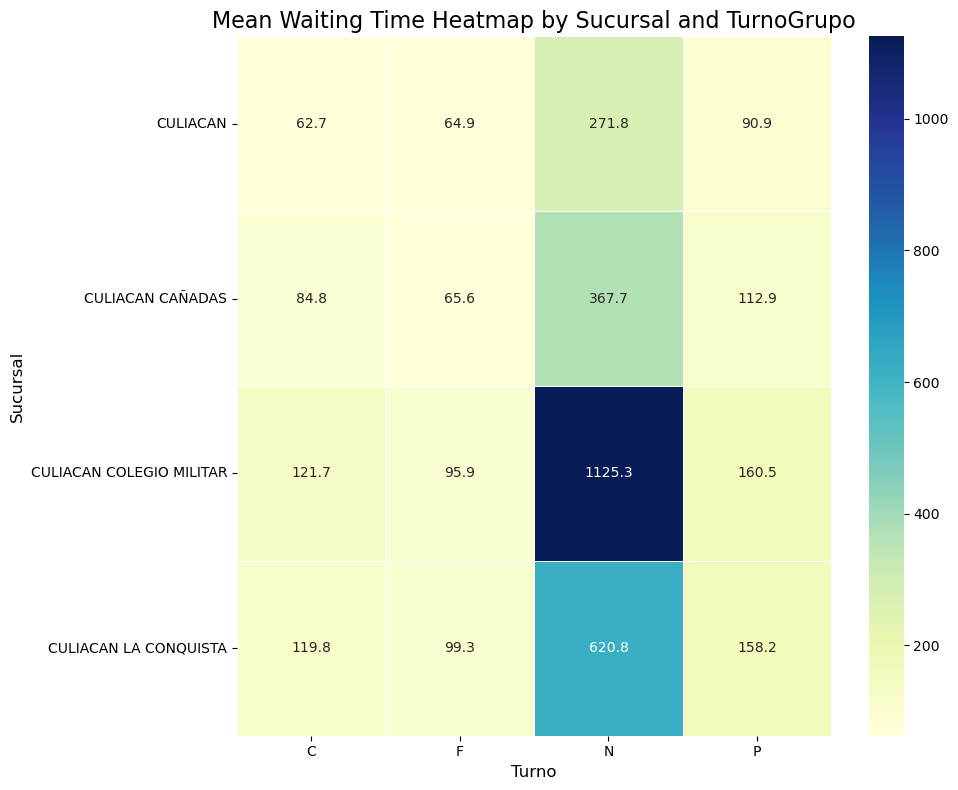

In [20]:
plt.show()

In [21]:
# Analyze by time of day
clinics_df['TurnoInicioDateTime'].dt.hour.unique()


array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  5],
      dtype=int32)

In [22]:
# Delete observations with hours where the clinics are closed
clinics_df['HourOfDay'] = clinics_df['TurnoInicioDateTime'].dt.hour
clinics_df = clinics_df[clinics_df['HourOfDay'].between(5, 20)]

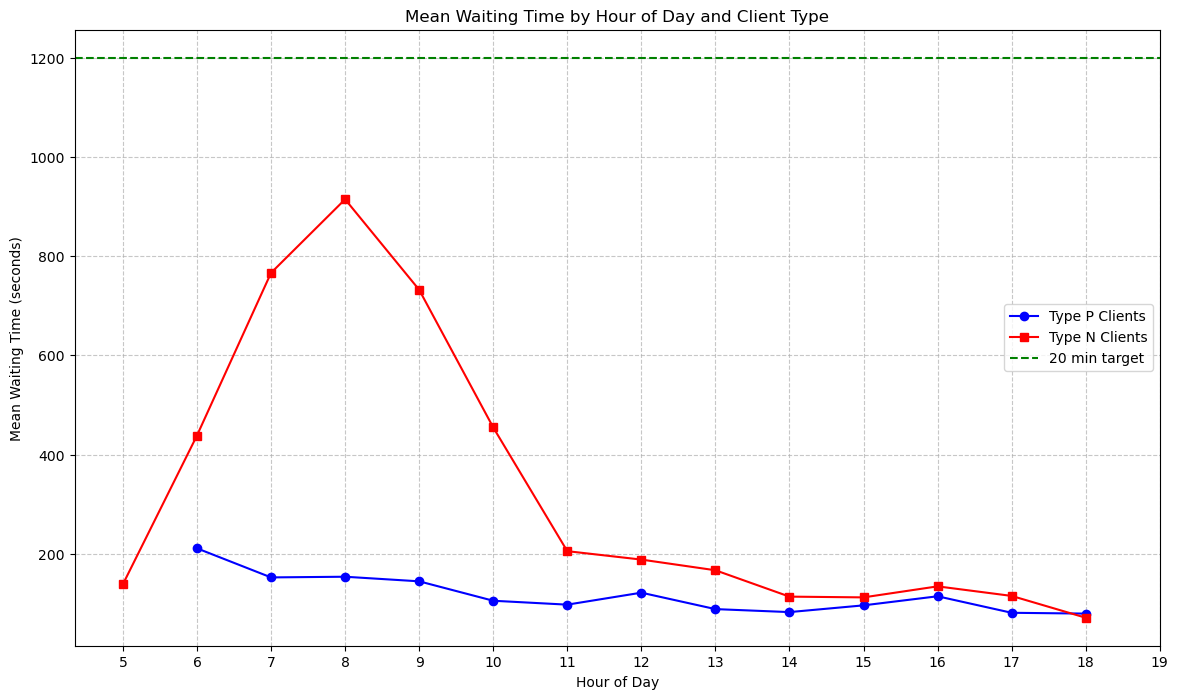

In [23]:
# Group by hour and client type
hourly_stats = clinics_df.groupby(
    ['HourOfDay', 'TurnoGrupo']
)['WaitingTimeInLine'].agg([
    'mean', 'median', 'count', ('75%', lambda x: x.quantile(0.75)),
]).reset_index()

hourly_stats['MeanWaitingTimeSeconds'] = hourly_stats['mean'].dt.total_seconds()
# Plot waiting times by hour and client type
plt.figure(figsize=(14, 8))

# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['MeanWaitingTimeSeconds'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], 
    type_b['MeanWaitingTimeSeconds'], 
    's-', label='Type N Clients', color='red'
)

# Add a horizontal line at 20 minutes
plt.axhline(y=1200, color='green', linestyle='--', label='20 min target')

plt.title('Mean Waiting Time by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Waiting Time (seconds)')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos que los clientes con turnos N en promedio esperan más que los clientes con turnos P sin importar la hora del día. Esto es verdadero para el conjunto de todas las sucursales.

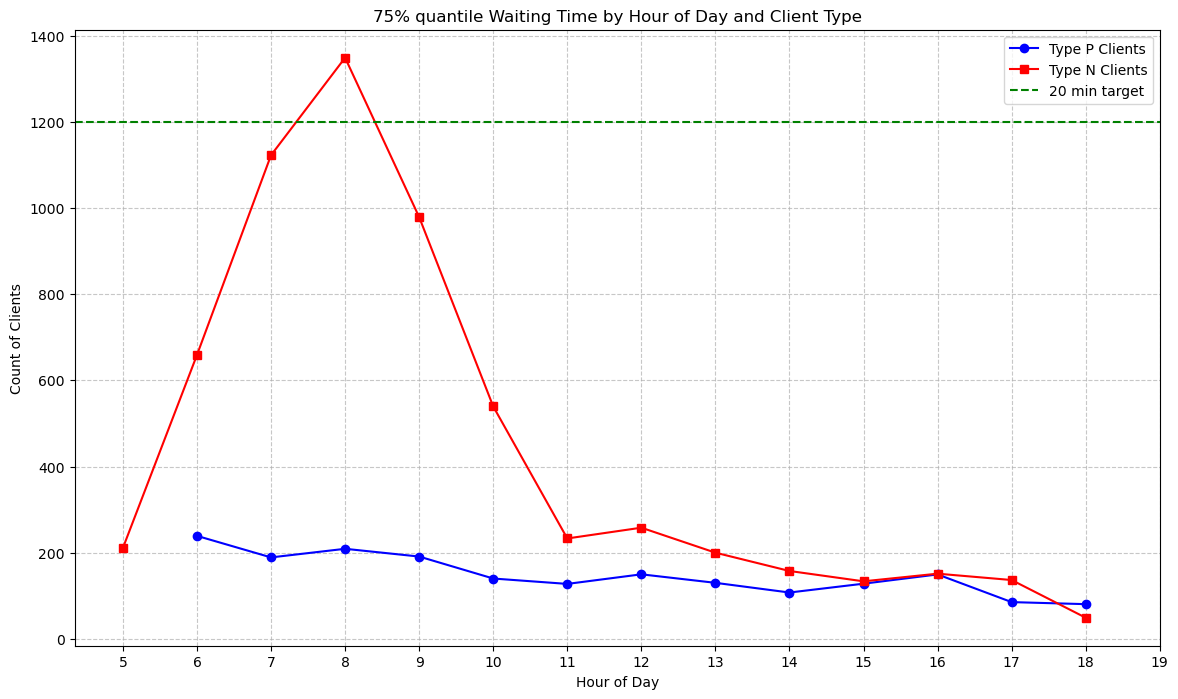

In [24]:
# Plot count of types of clientes each hour
plt.figure(figsize=(14, 8))
hourly_stats['75%WaitingTimeSeconds'] = hourly_stats['75%'].dt.total_seconds()
# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['75%WaitingTimeSeconds'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], 
    type_b['75%WaitingTimeSeconds'], 
    's-', label='Type N Clients', color='red'
)

# Add a horizontal line at 20 minutes
plt.axhline(y=1200, color='green', linestyle='--', label='20 min target')

plt.title('75% quantile Waiting Time by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Clients')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos el mismo comportamiento para el quantil 0.75. 

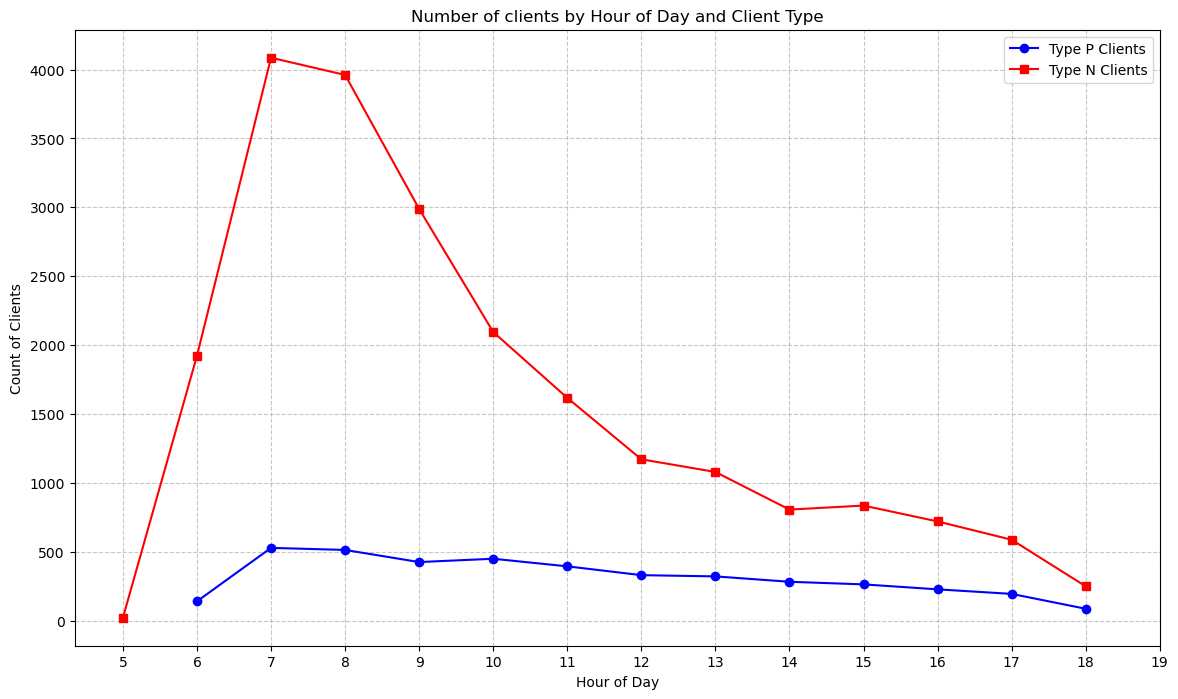

In [26]:
# Plot count of types of clientes each hour
plt.figure(figsize=(14, 8))

# Plot for Type A
type_a = hourly_stats[hourly_stats['TurnoGrupo'] == 'P']
plt.plot(
    type_a['HourOfDay'], 
    type_a['count'], 
    'o-', label='Type P Clients', color='blue'
)

# Plot for Type B
type_b = hourly_stats[hourly_stats['TurnoGrupo'] == 'N']
plt.plot(
    type_b['HourOfDay'], type_b['count'], 
    's-', label='Type N Clients', color='red'
)

plt.title('Number of clients by Hour of Day and Client Type')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Clients')
plt.xticks(range(5, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Observamos como a cualquier hora del día hay más clientes tipo N que tipo P. Esto es verdadero para el conjunto de todas las sucursales en la base de datos.

# Exploración sobre el tiempo de atención en ventanilla

In [28]:
clinics_df['TimeInService'] = pd.to_timedelta(
    clinics_df['TAPRecepcionMinutos'], 
    unit='m', errors='coerce'
)

In [29]:
clinics_df.groupby('TurnoGrupo')['TimeInService'].agg('mean')

TurnoGrupo
C   0 days 00:03:41.307112140
F   0 days 00:03:26.737333333
N   0 days 00:03:38.923620215
P   0 days 00:02:41.091113028
Name: TimeInService, dtype: timedelta64[ns]

In [30]:
clinics_df['TimeInService'].isna().sum() / clinics_df.shape[0]

np.float64(0.13938125449669697)

Casi 14% de los datos tienen valores faltantes en el tiempo de atención en ventanilla

In [31]:
clinics_df.groupby('Sucursal')['TimeInService'].apply(
    lambda x: x.isna().sum() / x.size
).reset_index()

,Sucursal,TimeInService
0,CULIACAN,0.136917
1,CULIACAN CAÑADAS,0.185835
2,CULIACAN COLEGIO MILITAR,0.090451
3,CULIACAN LA CONQUISTA,0.153556


In [32]:
clinics_df.groupby('TurnoGrupo')['TimeInService'].apply(
    lambda x: x.isna().sum() / x.size
).reset_index()

,TurnoGrupo,TimeInService
0,C,0.081434
1,F,0.097292
2,N,0.145542
3,P,0.162572


In [44]:
clinics_df.columns

Index(['Orden', 'Sucursal', 'FechaID', 'HoraLLegada', 'TurnoID', 'Turno',
       'TurnoTipo', 'TurnoHoraInicio', 'TurnoHoraFin', 'TurnoMinutosEspera',
       'TAPRecepcionMinutos', 'TAPRecepcionCaja', 'TurnoInicioDateTime',
       'TurnoFinDateTime', 'TurnoGrupo', 'WaitingTimeInLine', 'HourOfDay',
       'TimeInService', 'HasTimeInService'],
      dtype='object')

Hay que investigar la razón por la cuál hay valores faltantes en el tiempo de servicio en ventanilla.

In [40]:
# Label observations as 1: has time in service, 0: NaT
clinics_df['HasTimeInService'] = clinics_df['TimeInService'].apply(
    lambda x: 1 if isinstance(x, pd.Timedelta) else 0
)

In [47]:
clinics_df.groupby('HasTimeInService')[['WaitingTimeInLine']].agg([
    'mean', 'median', 'count', ('75%', lambda x: x.quantile(0.75))
])

WaitingTimeInLine                         \
                                      mean          median  count   
HasTimeInService                                                    
0                0 days 00:08:20.141952135 0 days 00:02:24   4262   
1                0 days 00:06:41.351459188 0 days 00:01:56  26316   

                                         
                                    75%  
HasTimeInService                         
0                0 days 00:09:37.750000  
1                       0 days 00:07:36

En promedio, los clientes que en la base de datos no tienen registro de su tiempo en ventanilla esperaron más (1 minuto 40 segundos más) que los clientes que sí tiene registro de su tiempo en ventanilla. Esto nos hace pensar que una razón por la cuál ese registro no existe es porque esos clientes decidieron marcharse de la clínica antes de ser atendidos.

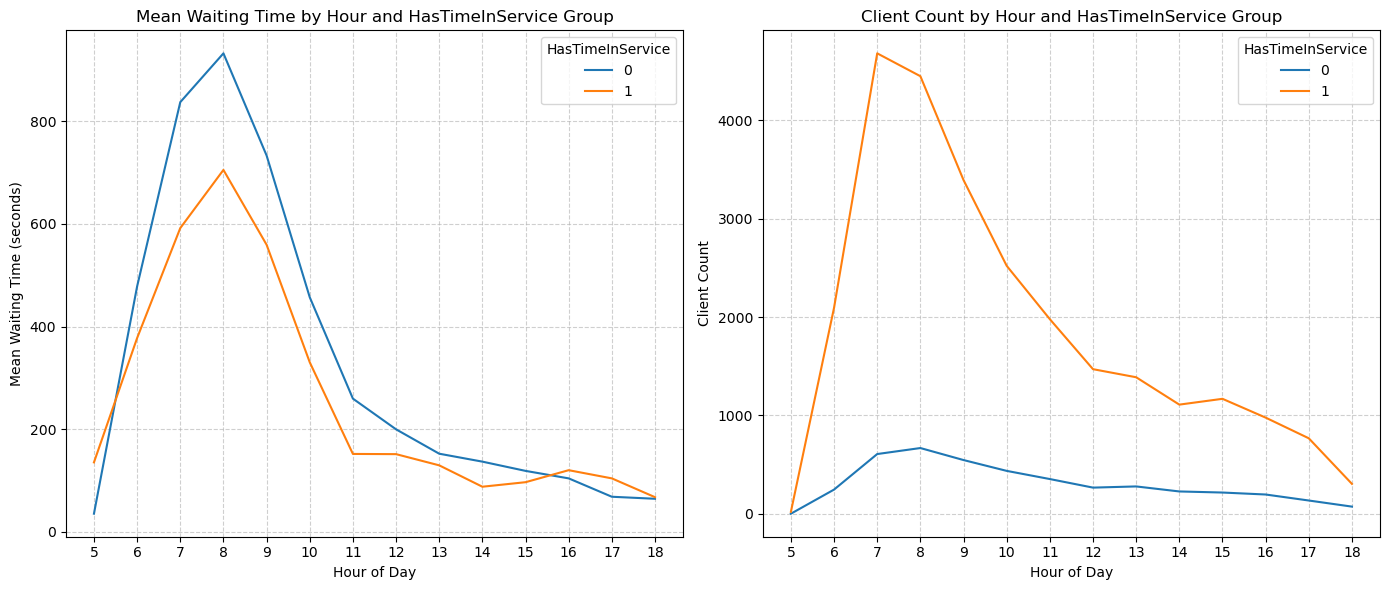

In [67]:
# Your original groupby and aggregation
agg_df = clinics_df.groupby(
    ['HourOfDay', 'HasTimeInService']
)[['WaitingTimeInLine']].agg([
    'mean', 'median', 'count', ('75%', lambda x: x.quantile(0.75))
])

# 1. Select the 'mean' column for 'WaitingTimeInLine'
# The column name is ('WaitingTimeInLine', 'mean') because of the multi-level columns
mean_waiting_time_series = agg_df[('WaitingTimeInLine', 'mean')]

# 2. Unstack the 'HasTimeInService' level from the index
# This moves 'HasTimeInService' from the row index to the column index,
# creating separate columns for each True/False group.
mean_waiting_time_unstacked = mean_waiting_time_series.unstack()
mean_waiting_time_unstacked = mean_waiting_time_unstacked.apply(
    lambda x: x.dt.total_seconds()
)
# Plot clients count by hour and hastimeinservice
count_clients_time_series = agg_df[('WaitingTimeInLine', 'count')]

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1 row, 2 columns

# --- Plot the first graph on the left axis (axes[0]) ---
mean_waiting_time_unstacked.plot(kind='line', ax=axes[0]) # Pass the axis object

# Add plot details for the left plot
axes[0].set_title('Mean Waiting Time by Hour and HasTimeInService Group')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Mean Waiting Time (seconds)')
axes[0].set_xticks(mean_waiting_time_unstacked.index) # Ensure all hour values are tick marks
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(title='HasTimeInService')

# --- Plot the second graph on the right axis (axes[1]) ---
count_clients_time_unstacked.plot(kind='line', ax=axes[1]) # Pass the axis object

# Add plot details for the right plot
axes[1].set_title('Client Count by Hour and HasTimeInService Group')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Client Count')
axes[1].set_xticks(count_clients_time_unstacked.index) # Use the same ticks for consistency
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(title='HasTimeInService')

# --- Display the plots ---
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

Observamos que en el horario en que las clínicas están más congestionadas existen muchos más registros de clientes con tiempo en ventanilla, pero aquellos que no lo tienen, en promedio, esperaron más en la fila antes de ser atendidos. Esto refuerza nuestro pensamiento sobre que esos clientes se fueron de la clínica antes de ser atendidos.

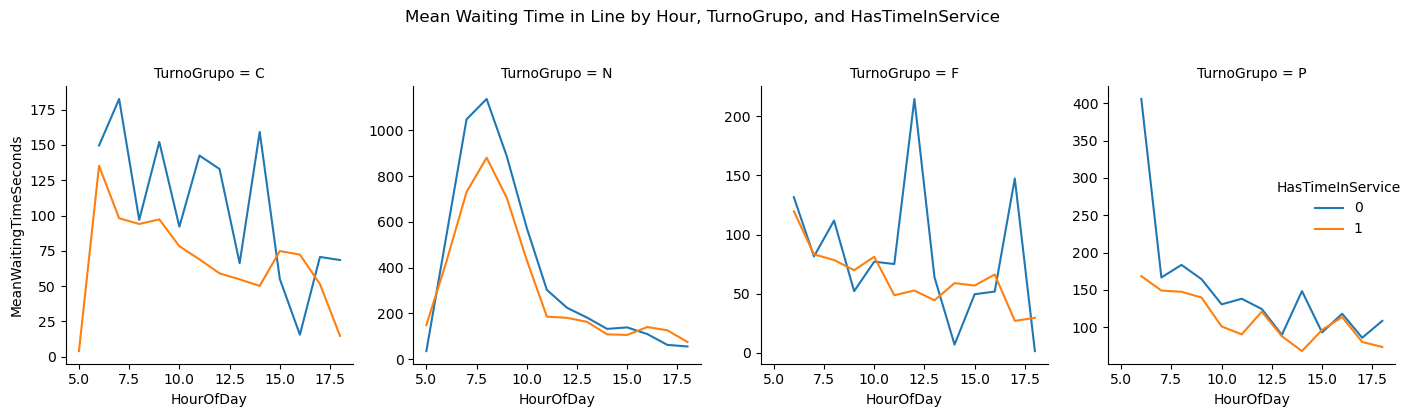

In [93]:
# Your groupby and aggregation
agg_df_new = clinics_df.groupby(
    ['HourOfDay', 'TurnoGrupo', 'HasTimeInService']
)[['WaitingTimeInLine']].agg([
    'mean', 'median', 'count', ('75%', lambda x: x.quantile(0.75))
])

# --- Corrected Data Preparation for Seaborn ---

# 1. Select *only* the 'mean' column(s) as a DataFrame slice
# Use double brackets [[...]] to keep it as a DataFrame
mean_df = agg_df_new[[('WaitingTimeInLine', 'mean')]]

# 2. Flatten the column MultiIndex by renaming the single column
mean_df.columns = ['MeanWaitingTime'] # Assign a simple string name

# 3. Reset the index to turn 'HourOfDay', 'TurnoGrupo', 'HasTimeInService' into columns
mean_data_for_seaborn = mean_df.reset_index()
mean_data_for_seaborn['MeanWaitingTimeSeconds'] = mean_data_for_seaborn['MeanWaitingTime'].dt.total_seconds()

# --- Create the faceted plot using Seaborn ---

g = sns.relplot(
    data=mean_data_for_seaborn, # Use the correctly prepared DataFrame
    x='HourOfDay',
    y='MeanWaitingTimeSeconds',        # This column now exists
    col='TurnoGrupo',
    hue='HasTimeInService',
    kind='line',
    height=4,
    aspect=0.8,
    facet_kws={'sharey': False}
)

g.fig.suptitle('Mean Waiting Time in Line by Hour, TurnoGrupo, and HasTimeInService', y=1.03)

plt.tight_layout()
plt.show()

Independientemente del tipo de turno (C, F, N, P) que se tenga, los clientes sin registro de tiempo de espera en ventanilla en promedio esperaron más tiempo que el resto de clientes.

In [95]:
clinics_df['HasTimeInService'].value_counts() / clinics_df.shape[0]

HasTimeInService
1    0.860619
0    0.139381
Name: count, dtype: float64

El 14% de toda la base tiene datos faltantes en el tiempo de servicio. El tiempo de servicio y el número de agentes son factores que afectan el tiempo en cola de los clientes. Eliminar estas observaciones introduciría un sesgo sistemático, subestimando el tiempo de espera real promedio y, lo que es más importante, eliminando precisamente los casos más problemáticos (esperas largas) que los modelos y simulaciones necesitan entender y abordar. Perderíamos información crucial sobre el comportamiento del sistema bajo estrés y sobre la experiencia de una porción significativa de clientes (aquellos que potencialmente abandonaron). El resultado sería un modelo basado en una realidad "idealizada" donde todos son atendidos y las esperas largas que llevan al abandono son ignoradas.

La hipótesis más plausible para la falta de `TimeInService` en conjunción con un `WaitingTimeInLine` más largo es el abandono de la cola. Si un cliente se va antes de llegar a la ventanilla, nunca tuvo un tiempo de atención. Imputar un valor (sea la media, mediana u otro) es fabricar un dato que contradice la realidad de esa observación. Estaríamos asumiendo artificialmente que todos los clientes que entraron fueron eventualmente atendidos en ventanilla. El impacto de hacer una imputación de este 14% es que distorsionaría las métricas relacionadas con la atención real en ventanilla (ej. tasa de servicio, utilización de ventanillas). Aunque preservaríamos los datos de `WaitingTimeInLine` de estos clientes (lo cual es bueno), estaríamos creando una inconsistencia lógica en los datos al asignarles un tiempo de servicio que no ocurrió.

**La Mejor Estrategia: Tratar la Ausencia como Información**

Dado que la ausencia del `TimeInService` probablemente significa un evento específico (abandono), la mejor manera de proceder es tratar esta ausencia como información valiosa en sí misma, en lugar de como un simple dato faltante a eliminar o rellenar.

In [100]:
clinics_df.head()

,Orden,Sucursal,FechaID,HoraLLegada,TurnoID,Turno,TurnoTipo,TurnoHoraInicio,TurnoHoraFin,TurnoMinutosEspera,TAPRecepcionMinutos,TAPRecepcionCaja,TurnoInicioDateTime,TurnoFinDateTime,TurnoGrupo,WaitingTimeInLine,HourOfDay,TimeInService,HasTimeInService
29072,424722,CULIACAN,2024-03-01,6,41691626,P001,Estudio Pendiente,06:32:32,06:34:58,2.43,0.58,1135.0,2024-03-01 06:32:32,2024-03-01 06:34:58,P,0 days 00:02:26,6,0 days 00:00:34.800000,1
29073,424738,CULIACAN,2024-03-01,6,41696473,N020,Solicitar Estudios,06:47:18,07:06:33,19.25,4.42,1134.0,2024-03-01 06:47:18,2024-03-01 07:06:33,N,0 days 00:19:15,6,0 days 00:04:25.200000,1
29074,424754,CULIACAN,2024-03-01,7,41696082,C007,Citado,07:03:23,07:04:14,0.85,2.97,1136.0,2024-03-01 07:03:23,2024-03-01 07:04:14,C,0 days 00:00:51,7,0 days 00:02:58.200000,1
29075,424770,CULIACAN,2024-03-01,7,41701275,N039,Solicitar Estudios,07:18:33,07:33:59,15.43,1.68,1137.0,2024-03-01 07:18:33,2024-03-01 07:33:59,N,0 days 00:15:26,7,0 days 00:01:40.800000,1
29076,424786,CULIACAN,2024-03-01,7,41704260,N050,Solicitar Estudios,07:30:09,07:50:12,20.05,4.68,1134.0,2024-03-01 07:30:09,2024-03-01 07:50:12,N,0 days 00:20:03,7,0 days 00:04:40.800000,1
